In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import seaborn as sns

#### Step 1
- Create a dataframe for model. Here, x1 and x2 are input features and class is target feature.

In [187]:
data = pd.DataFrame()
data['x1'] = [17,6,9,1,5,17,7,8,6,19]
data['x2'] = [4,3,8,13,8,2,4,7,20,4]
data['class'] = [1,0,1,1,0,1,0,0,1,0]

In [188]:
data

,x1,x2,class
0,17,4,1
1,6,3,0
2,9,8,1
3,1,13,1
4,5,8,0
5,17,2,1
6,7,4,0
7,8,7,0
8,6,20,1
9,19,4,0


<AxesSubplot:xlabel='x1', ylabel='x2'>

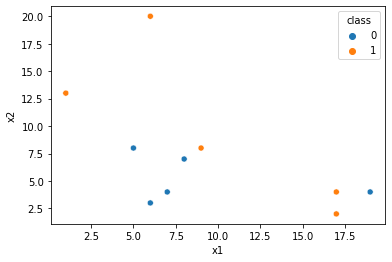

In [189]:
sns.scatterplot(x=data['x1'],y=data['x2'],hue=data['class'])

- As shown in the plot, the points are not following any special patterns.

#### Step 2
- In the next step, algorithm gives equal initial weights(1/number of rows in data) to all the points in data.

In [190]:
data['int_weight'] = 1/data.shape[0]

In [191]:
data

,x1,x2,class,int_weight
0,17,4,1,0.1
1,6,3,0,0.1
2,9,8,1,0.1
3,1,13,1,0.1
4,5,8,0,0.1
5,17,2,1,0.1
6,7,4,0,0.1
7,8,7,0,0.1
8,6,20,1,0.1
9,19,4,0,0.1


#### Step 3
- Now the data is ready. Let's initialize our first weak learner, that is decision tree with depth = 1, which is also known as decision stump. 

In [192]:
from sklearn.tree import DecisionTreeClassifier
dt1 = DecisionTreeClassifier(max_depth=1)

In [193]:
X = data.drop(['class','int_weight'],axis=1).values
y = data['class'].values

In [194]:
dt1.fit(X,y)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'X[1] <= 10.5\ngini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.25, 0.25, 'gini = 0.469\nsamples = 8\nvalue = [5, 3]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]')]

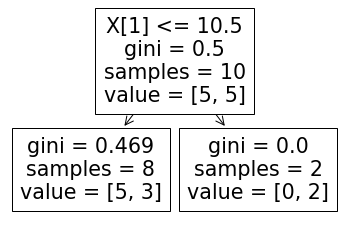

In [195]:
from sklearn.tree import plot_tree
plot_tree(dt1)

<AxesSubplot:>

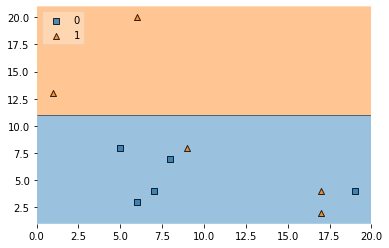

In [196]:
plot_decision_regions(X,y,clf=dt1,legend=2 )

- So, in the prediction of first decision tree, three points are predicted wrongly.

In [197]:
data['pred'] = dt1.predict(X)
data

,x1,x2,class,int_weight,pred
0,17,4,1,0.1,0
1,6,3,0,0.1,0
2,9,8,1,0.1,0
3,1,13,1,0.1,1
4,5,8,0,0.1,0
5,17,2,1,0.1,0
6,7,4,0,0.1,0
7,8,7,0,0.1,0
8,6,20,1,0.1,1
9,19,4,0,0.1,0


#### Step 4
- Now calculate the performance score of model in the final result. Score = (0.5)*log((1-error)/error)
- In the score formula, the denominator just has error term. When the error becomes zero, the formula will break. To solve this issue a very small number can be added in the denominator.

In [198]:
def cal_weight(data):
    incorrect = 0
    for i in range(data.shape[0]):
        if data.iloc[i,2] != data.iloc[i,4]:
            incorrect = incorrect + 1
    error = incorrect/data.shape[0]
    weight = (0.5)*(np.log((1-error)/(error+0.0000000001)))
    return weight

In [199]:
weight1 = cal_weight(data)
weight1

0.42364893002693516

#### Step 5
- Now, to do the up sampling of incorrectly classified points, the model define new weights for the points. 
- The model gives higher weights = (initial weight * e^(performance score)) to incorrect predicts and lower weights = (initial weight * e^(-performance score))

In [200]:
def new_weight(row, weight):
    if row['class'] == row['pred']:
        new_weight = row['int_weight']*np.exp(-weight)
    else:
        new_weight = row['int_weight']*np.exp(weight)
    return new_weight

In [201]:
data['new_weight'] = data.apply(lambda x:new_weight(x,weight1),axis=1)

In [202]:
data

,x1,x2,class,int_weight,pred,new_weight
0,17,4,1,0.1,0,0.152753
1,6,3,0,0.1,0,0.065465
2,9,8,1,0.1,0,0.152753
3,1,13,1,0.1,1,0.065465
4,5,8,0,0.1,0,0.065465
5,17,2,1,0.1,0,0.152753
6,7,4,0,0.1,0,0.065465
7,8,7,0,0.1,0,0.065465
8,6,20,1,0.1,1,0.065465
9,19,4,0,0.1,0,0.065465


#### Step 6
- Normalize the new weight by dividing weights by sum of all the weights. By this step, all the weights will be converted to the range of 0 to 1.

In [149]:
data['norm_weight'] = data['new_weight']/data.new_weight.sum()

In [150]:
data

,x1,x2,class,int_weight,pred,new_weight,norm_weight
0,17,4,1,0.1,0,0.152753,0.166667
1,6,3,0,0.1,0,0.065465,0.071429
2,9,8,1,0.1,0,0.152753,0.166667
3,1,13,1,0.1,1,0.065465,0.071429
4,5,8,0,0.1,0,0.065465,0.071429
5,17,2,1,0.1,0,0.152753,0.166667
6,7,4,0,0.1,0,0.065465,0.071429
7,8,7,0,0.1,0,0.065465,0.071429
8,6,20,1,0.1,1,0.065465,0.071429
9,19,4,0,0.1,0,0.065465,0.071429


#### Step 7
- Now define upper and lower limit by adding new weights in cumsum manner and divide the data in bins.

In [151]:
def define_range(data):
    data['upper_limit'] = data['norm_weight'].cumsum()
    data['lower_limit'] = data['upper_limit'] - data['norm_weight']
    return data

In [152]:
data = define_range(data)
data[['x1','x2','class','int_weight','pred','new_weight','norm_weight','lower_limit','upper_limit']]

,x1,x2,class,int_weight,pred,new_weight,norm_weight,lower_limit,upper_limit
0,17,4,1,0.1,0,0.152753,0.166667,0.000000,0.166667
1,6,3,0,0.1,0,0.065465,0.071429,0.166667,0.238095
2,9,8,1,0.1,0,0.152753,0.166667,0.238095,0.404762
3,1,13,1,0.1,1,0.065465,0.071429,0.404762,0.476190
4,5,8,0,0.1,0,0.065465,0.071429,0.476190,0.547619
5,17,2,1,0.1,0,0.152753,0.166667,0.547619,0.714286
6,7,4,0,0.1,0,0.065465,0.071429,0.714286,0.785714
7,8,7,0,0.1,0,0.065465,0.071429,0.785714,0.857143
8,6,20,1,0.1,1,0.065465,0.071429,0.857143,0.928571
9,19,4,0,0.1,0,0.065465,0.071429,0.928571,1.000000


#### Step 8
- Now the model will randomly generate same number of points as in data in range 0 to 1 and select the data point for which the random point is in the range of upper and lower limit.
- The points with incorrect classification has wilder range of values in limits, the probability of them getting selected is higher, and that is how they are up sampled.

In [153]:
def get_indices(data):

    indices = []
    for i in range(data.shape[0]):
        n = np.random.random()
        for index, row in data.iterrows():
            if row['lower_limit'] < n and row['upper_limit'] > n:
                indices.append(index)
    return indices

In [154]:
indices = get_indices(data)
indices

[3, 4, 6, 9, 8, 7, 3, 9, 9, 4]

- For new data, choose the points of with index selected by random numbers and repeat all the steps given above.
- Remember, every time before initializing a new weak learner, all the points are given equal weights.

In [155]:
sec_data = data.iloc[indices,[0,1,2,3]]
sec_data

,x1,x2,class,int_weight
3,1,13,1,0.1
4,5,8,0,0.1
6,7,4,0,0.1
9,19,4,0,0.1
8,6,20,1,0.1
7,8,7,0,0.1
3,1,13,1,0.1
9,19,4,0,0.1
9,19,4,0,0.1
4,5,8,0,0.1


In [156]:
dt2 = DecisionTreeClassifier(max_depth=1)

In [157]:
X = sec_data[['x1','x2']].values
y = sec_data['class'].values

In [158]:
dt2.fit(X,y)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'X[1] <= 10.5\ngini = 0.42\nsamples = 10\nvalue = [7, 3]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]')]

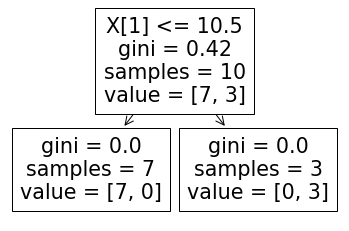

In [159]:
plot_tree(dt2)

<AxesSubplot:>

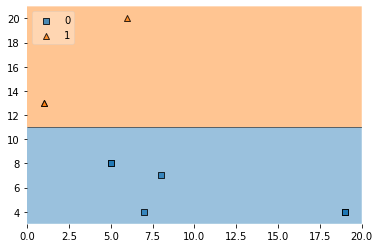

In [160]:
plot_decision_regions(X,y,clf=dt2,legend=2 )

In [161]:
y_pred = dt2.predict(X)
sec_data['pred'] = y_pred
sec_data

,x1,x2,class,int_weight,pred
3,1,13,1,0.1,1
4,5,8,0,0.1,0
6,7,4,0,0.1,0
9,19,4,0,0.1,0
8,6,20,1,0.1,1
7,8,7,0,0.1,0
3,1,13,1,0.1,1
9,19,4,0,0.1,0
9,19,4,0,0.1,0
4,5,8,0,0.1,0


In [162]:
weight2 = cal_weight(sec_data)

In [163]:
sec_data['new_weight'] = sec_data.apply(lambda x:new_weight(x,weight2),axis=1)

In [164]:
sec_data['norm_weight'] = sec_data['new_weight']/sec_data.new_weight.sum()

In [165]:
sec_data = define_range(sec_data)
sec_data[['x1','x2','class','int_weight','pred','new_weight','norm_weight','lower_limit','upper_limit']]

,x1,x2,class,int_weight,pred,new_weight,norm_weight,lower_limit,upper_limit
3,1,13,1,0.1,1,0.065465,0.1,0.0,0.1
4,5,8,0,0.1,0,0.065465,0.1,0.1,0.2
6,7,4,0,0.1,0,0.065465,0.1,0.2,0.3
9,19,4,0,0.1,0,0.065465,0.1,0.3,0.4
8,6,20,1,0.1,1,0.065465,0.1,0.4,0.5
7,8,7,0,0.1,0,0.065465,0.1,0.5,0.6
3,1,13,1,0.1,1,0.065465,0.1,0.6,0.7
9,19,4,0,0.1,0,0.065465,0.1,0.7,0.8
9,19,4,0,0.1,0,0.065465,0.1,0.8,0.9
4,5,8,0,0.1,0,0.065465,0.1,0.9,1.0


In [166]:
indices = get_indices(sec_data)
indices

[3, 4, 3, 6, 9, 9, 9, 7, 7, 9]

In [167]:
third_data = sec_data.iloc[indices,[0,1,2,3]]
third_data

,x1,x2,class,int_weight
9,19,4,0,0.1
8,6,20,1,0.1
9,19,4,0,0.1
3,1,13,1,0.1
4,5,8,0,0.1
4,5,8,0,0.1
4,5,8,0,0.1
9,19,4,0,0.1
9,19,4,0,0.1
4,5,8,0,0.1


In [203]:
dt3 = DecisionTreeClassifier()

In [204]:
X = third_data[['x1','x2']].values
y = third_data['class'].values

In [205]:
dt3.fit(X,y)

DecisionTreeClassifier()

[Text(0.5, 0.75, 'X[1] <= 10.5\ngini = 0.32\nsamples = 10\nvalue = [8, 2]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]')]

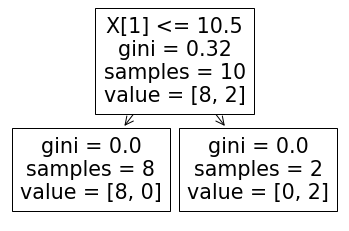

In [206]:
plot_tree(dt3)

<AxesSubplot:>

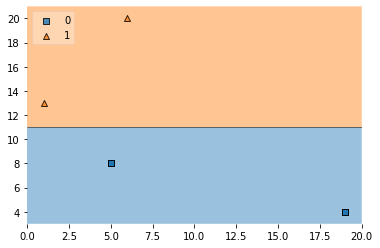

In [207]:
plot_decision_regions(X,y,dt3,legend=2)

In [209]:
third_data['pred'] = dt3.predict(X)

In [210]:
weight3 = cal_weight(third_data)
weight3

11.512925464970229

In [212]:
print('Score for model 1:',weight1)
print('Score for model 2:',weight2)
print('Score for model 3:',weight3)

Score for model 1: 0.42364893002693516
Score for model 2: 1.0986122881681097
Score for model 3: 11.512925464970229


#### Test Model:

In [227]:
test = np.array([5,8]).reshape(1, 2)

In [228]:
predict1 = dt1.predict(test)
predict1

array([0], dtype=int64)

In [229]:
predict2 = dt2.predict(test)
predict2

array([0], dtype=int64)

In [230]:
predict3 = dt3.predict(test)
predict3

array([0], dtype=int64)

In [231]:
answer = weight1*(-1) + weight2*(-1) + weight3*(-1)
answer

-13.035186683165273

- As the final answer has -ve sigh, the class is 0.